In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from random import gauss
from scipy.io import wavfile
import csv
from scipy import signal
import librosa

In [2]:
#change the working directory to the Data directory
os.chdir("C:\\Users\\b9027741\\OneDrive - Newcastle University\\Masters\\Computer Science\\Machine_Learning_Project\\Data")

In [36]:
#labels needed - using the 6 I have specified
labels = ["yes", "no", "up", "down", "left", "right"]

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [32]:
def wav_plot(audio, sample_rate=16000):
    signal_data, sample_rate = librosa.load(audio,sr=16000)
    return signal_data

(161, 88)

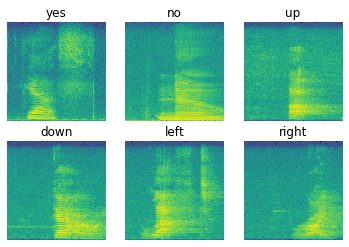

In [25]:
audio_labels = ["yes/00f0204f_nohash_0.wav","no/0a9f9af7_nohash_0.wav","up/00b01445_nohash_0.wav",
               "down/00b01445_nohash_0.wav","left/00b01445_nohash_0.wav","right/00b01445_nohash_0.wav"]

for i in range(1,7):
    plt.subplot(2,3,i)
    sample_rate, audio = wavfile.read("train/audio/"+audio_labels[i-1])
    _, spectrogram = log_specgram(audio,sample_rate)
    plt.imshow(spectrogram.T,aspect='auto',origin='lower')
    plt.title(labels[i-1])
    plt.axis("off")

spectrogram.T.shape

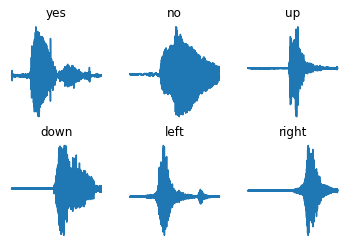

In [33]:
for i in range(1,7):
    plt.subplot(2,3,i)
    sig_data = wav_plot(("train/audio/"+audio_labels[i-1]))
    plt.plot(sig_data)
    plt.title(labels[i-1])
    plt.axis("off")

In [38]:
all_files = pd.DataFrame(columns=("file_name","label"))
all_files = all_files.fillna(0)

for label in labels:
    files = os.listdir("train/audio/" + label)
    for file in files:
        all_files = all_files.append({
                    "file_name":file,
                    "label":label
                    },ignore_index=True)

print(all_files.head())

               file_name label
0  004ae714_nohash_0.wav   yes
1  004ae714_nohash_1.wav   yes
2  00f0204f_nohash_0.wav   yes
3  00f0204f_nohash_1.wav   yes
4  00f0204f_nohash_2.wav   yes


In [43]:
print(all_files["label"].value_counts())
print(all_files.shape)

yes      2377
no       2375
up       2375
right    2367
down     2359
left     2353
Name: label, dtype: int64
(14206, 2)


In [62]:
#train / test split

training_files = all_files.sample(frac=0.9,random_state=42)
test_files = all_files.drop(training_files.index)

print(training_files.head())
print(test_files.head())

print("training_files shape: " + str(training_files.shape))
print("test_files shape: " + str(test_files.shape))

                   file_name  label
8572   a42a88ff_nohash_0.wav   down
4098   bd8412df_nohash_1.wav     no
14004  eb0676ec_nohash_0.wav  right
7562   33f60c62_nohash_0.wav   down
12213  2f813234_nohash_1.wav  right
                file_name label
4   00f0204f_nohash_2.wav   yes
5   012c8314_nohash_0.wav   yes
9   0132a06d_nohash_3.wav   yes
55  05b2db80_nohash_2.wav   yes
64  06a79a03_nohash_0.wav   yes
training_files shape: (12785, 2)
test_files shape: (1421, 2)


In [63]:
#train / validation split

train_files = training_files.sample(frac=0.8,random_state=42)
validation_files = training_files.drop(train_files.index)

print(train_files.head(10))
print(validation_files.head())

print("training_files shape: " + str(train_files.shape))
print("validation_files shape: " + str(validation_files.shape))

#we now have the train/validation and test split needed
#train_files
#validation_files
#test_files

                   file_name label
3438   78884794_nohash_2.wav    no
10731  8c7c9168_nohash_2.wav  left
9682   19f9c115_nohash_0.wav  left
321    24befdb3_nohash_2.wav   yes
6140   9886d8bf_nohash_4.wav    up
1775   c22d3f18_nohash_0.wav   yes
5197   333784b7_nohash_1.wav    up
1932   d1214f15_nohash_1.wav   yes
1397   9a7c1f83_nohash_1.wav   yes
2361   fde2dee7_nohash_0.wav   yes
                   file_name  label
4098   bd8412df_nohash_1.wav     no
12213  2f813234_nohash_1.wav  right
3233   64da5281_nohash_2.wav     no
8757   b83c1acf_nohash_3.wav   down
7495   2bfe70ef_nohash_0.wav   down
training_files shape: (10228, 2)
validation_files shape: (2557, 2)


In [51]:
def wav2spec(wav_name,directory):
    
    sample_rate, samples = wavfile.read(directory + wav_name)
    
    #padding included but dont think it will be needed
    if (len(samples) < 16000):
        samples = np.pad(samples, (0, (16000 - len(samples))), "linear_ramp")
    
    _, spectrogram = log_specgram(samples,sample_rate)
    
    return spectrogram.T

In [70]:
def create_data(files,directory="train/audio/"):
    X = np.zeros([files.shape[0],161,99])
    Y = np.zeros([files.shape[0]])
    index = 0
    for ind, row in files.iterrows():
        try:
            X[index] = wav2spec(row["file_name"],directory+row["label"]+"/")
        except ValueError:
            print(row,ValueError)
        Y[index] = labels.index(row["label"])
        index += 1
        
    return X, Y
    
X_train, Y_train = create_data(train_files)
X_val, Y_val = create_data(validation_files)
X_test, Y_test = create_data(test_files)

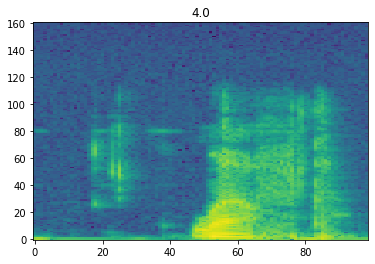

In [72]:
plt.imshow(X_train[1],aspect='auto',origin='lower')
plt.title(Y_train[1])
plt.show()

In [73]:
#save the data ready for the analysis
np.save("train/data/X_train", np.expand_dims(X_train,-1)+1.3)
np.save("train/data/Y_train",Y_train.astype(np.int))
np.save("train/data/X_val",np.expand_dims(X_val,-1)+1.3)
np.save("train/data/Y_val",Y_val.astype(np.int))
np.save("train/data/X_test",np.expand_dims(X_test,-1)+1.3)
np.save("train/data/Y_test",Y_test.astype(np.int))